In [26]:
import pandas as pd
import uproot
import os
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib widget

In [27]:
os.system("/opt/exp_soft/cms/t3/eos-login -username tcuisset")
#Data 100 GeV
input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/ntuples/v16/ntuple_484.root'

# Simulation 100 GeV v3 (sim_proton)
input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v3/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v5 (sim_noproton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v5/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'

# Simulation 100 GeV v7 (with proton)
#input_file = '/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/FTFP_BERT_EMN/v7_33m/electrons/ntuple_sim_config22_pdgID11_beamMomentum100_listFTFP_BERT_EMN_0000_1.root'
for array_i in uproot.iterate(input_file + ":trackimpactntupler/impactPoints", step_size="10MB", library="ak"):
    array_impact = array_i
    break

In [28]:
for array_i in uproot.iterate(input_file + ":rechitntupler/hits", step_size="20MB", library="ak",
    filter_name=["event", 'rechit_detid',
       'rechit_module', 'rechit_layer', 'rechit_chip', 'rechit_channel',
       'rechit_x', 'rechit_y', 'rechit_z', 'rechit_energy']):
    array_hits = array_i
    break

In [29]:
df_hits = ak.to_dataframe(array_hits, levelname=lambda i : {0 : "event_minus_one", 1:"rechit_id"}[i]).reset_index(level=1).reset_index(level=0, drop=True).set_index("event")
df_impact = ak.to_dataframe(array_impact, levelname=lambda i: {0 : "event_minus_one"}[i]).reset_index(drop=True).set_index("event")
df_full = pd.merge(df_hits, df_impact, on="event").set_index("rechit_id", append=True)

In [30]:
#Selections taken from Matteo Bonanomi : https://github.com/bonanomi/HGCALStandaloneAnalysis/blob/master/setup/reader.py
hit_sel = (
    (df_full.rechit_energy > 0.5) # Half-a-MIP cut
    # Kill faulty chips
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
    & ~((df_full.rechit_chip == 3) & (df_full.rechit_channel == 22)) & ~((df_full.rechit_module == 78) & (df_full.rechit_chip == 0)) & (((df_full.rechit_layer != 37) & (df_full.rechit_layer != 36)))
    & (df_full.ntracks == 1) & (df_full.dwcReferenceType == 13)
)
hit_sel.value_counts()

True     2214110
False     105201
dtype: int64

In [31]:
df_selected = df_full[hit_sel]

In [32]:
(abs(df_selected.b_x+2.7)>=1.).value_counts()

False    1471687
True      742423
Name: b_x, dtype: int64

<Axes: >

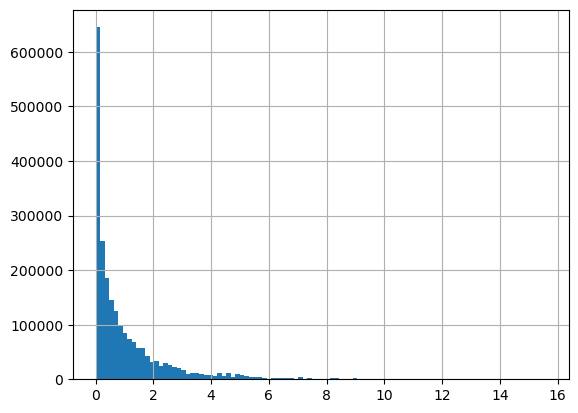

In [33]:
df_selected.trackChi2_X[df_selected.trackChi2_X < 100].hist(bins=100)